# 2 — DCGAN (CelebA)


In [1]:
import sys
sys.path.append('../src')
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import random
from PIL import Image
import csv
from utils import print_welcome_message, weights_init
from scipy.linalg import sqrtm
from torchvision.models import inception_v3
from train import Generator, Discriminator


# Configuración específica del notebook
NOTEBOOK_NAME = "2_dcgan_generation"
MODEL_NAME = "PROYECTO DCGAN - GENERACIÓN DE CARAS CELEBA"
print_welcome_message(f"Fashion-MNIST {MODEL_NAME}")
print(f"Notebook: {NOTEBOOK_NAME}")

PROYECTO FASHION-MNIST PROYECTO DCGAN - GENERACIÓN DE CARAS CELEBA
Silvia Sandoval - Portfolio Machine Learning
Notebook: 2_dcgan_generation


##  Setup del notebook

In [2]:
# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Configuración optimizada para CPU
dataroot = "../assets/img_align_celeba"
workers = 2
batch_size = 64  # Reducido para CPU
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 5  # Solo 5 épocas para prueba rápida
lr = 0.0002
beta1 = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")


Random Seed:  999
Usando dispositivo: cpu


##  Definición del modelo (Generator & Discriminator)

In [3]:
# Cargar dataset con límite para mayor velocidad
print("Cargando dataset CelebA...")
dataset = datasets.ImageFolder(
    root=dataroot,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

Cargando dataset CelebA...


## Entrenamiento (def de épocas y max_batches)

Dataset: 10000 imágenes
Batches por época: 157


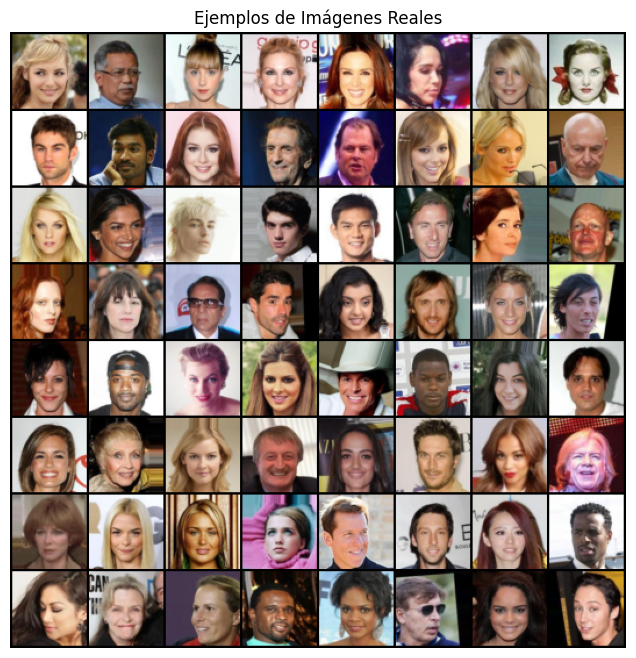

In [4]:
# Crear directorio de resultados
os.makedirs('../results/2_dcgan_generation', exist_ok=True)

# LIMITAR DATASET para mayor velocidad (solo 10,000 imágenes) 10000
dataset = torch.utils.data.Subset(dataset, range(min(10000, len(dataset))))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

print(f"Dataset: {len(dataset)} imágenes")
print(f"Batches por época: {len(dataloader)}")

# Mostrar imágenes de ejemplo
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Ejemplos de Imágenes Reales")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(), (1,2,0)))
plt.savefig('../results/2_dcgan_generation/real_samples.png')
plt.show()

## Métricas 

In [5]:
# Inicializar modelos
print("Inicializando modelos...")
netG = Generator(nz, ngf, nc).to(device)
netD = Discriminator(ndf, nc).to(device)

netG.apply(weights_init)
netD.apply(weights_init)

print("Generator:")
print(netG)
print("\nDiscriminator:")
print(netD)

# Setup de entrenamiento
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Inicializando modelos...
Generator:
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1),

## Entrenamiento

In [6]:
# Listas para tracking
img_list = []
G_losses = []
D_losses = []

print("\nIniciando entrenamiento...")
print("="*50)

start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    for i, data in enumerate(dataloader):
        # Actualizar Discriminador
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Actualizar Generator
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Guardar pérdidas
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Mostrar progreso
        if i % 100 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] '
                  f'Loss_D: {errD.item():.4f} '
                  f'Loss_G: {errG.item():.4f} '
                  f'D(x): {D_x:.4f} '
                  f'D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}')

    # Guardar imágenes generadas cada época
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
    
    # Guardar imagen de esta época
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title(f"Imágenes Generadas - Época {epoch}")
    plt.imshow(np.transpose(img_list[-1], (1,2,0)))
    plt.savefig(f'../results/2_dcgan_generation/epoch_{epoch}.png')
    plt.close()

    epoch_time = time.time() - epoch_start
    print(f'Época {epoch} completada en {epoch_time:.2f}s')

total_time = time.time() - start_time
print(f"\nEntrenamiento completado en {total_time:.2f} segundos")




Iniciando entrenamiento...
[0/5][0/157] Loss_D: 1.9728 Loss_G: 5.7708 D(x): 0.5810 D(G(z)): 0.6818/0.0043
[0/5][100/157] Loss_D: 0.2328 Loss_G: 6.9871 D(x): 0.9133 D(G(z)): 0.0942/0.0017
Época 0 completada en 372.65s
[1/5][0/157] Loss_D: 0.9641 Loss_G: 9.3024 D(x): 0.9672 D(G(z)): 0.5070/0.0006
[1/5][100/157] Loss_D: 0.3438 Loss_G: 4.2699 D(x): 0.8581 D(G(z)): 0.1228/0.0236
Época 1 completada en 341.52s
[2/5][0/157] Loss_D: 0.4749 Loss_G: 5.3063 D(x): 0.8924 D(G(z)): 0.2471/0.0115
[2/5][100/157] Loss_D: 0.4519 Loss_G: 4.5020 D(x): 0.7916 D(G(z)): 0.0930/0.0202
Época 2 completada en 351.20s
[3/5][0/157] Loss_D: 0.4079 Loss_G: 4.3381 D(x): 0.7971 D(G(z)): 0.0845/0.0339
[3/5][100/157] Loss_D: 1.1875 Loss_G: 5.4518 D(x): 0.5023 D(G(z)): 0.0049/0.0149
Época 3 completada en 331.62s
[4/5][0/157] Loss_D: 0.9407 Loss_G: 8.0684 D(x): 0.9435 D(G(z)): 0.4484/0.0007
[4/5][100/157] Loss_D: 1.2177 Loss_G: 9.9850 D(x): 0.9515 D(G(z)): 0.5816/0.0002
Época 4 completada en 328.89s

Entrenamiento complet

## Guardar modelos y graficos

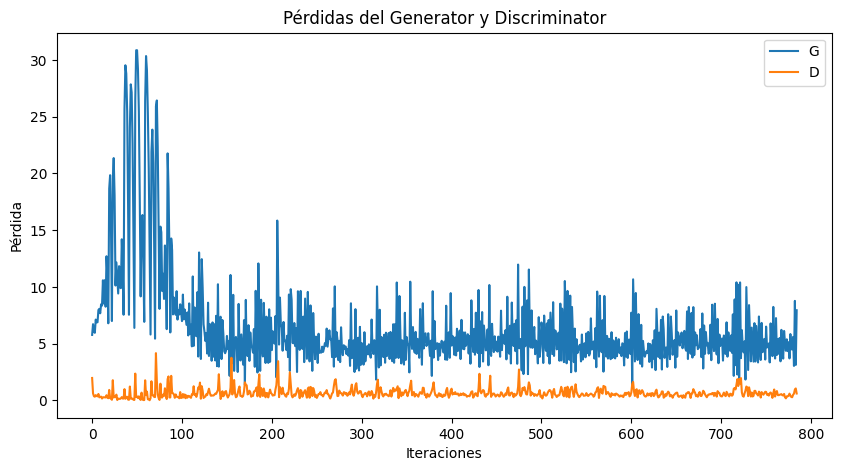

In [7]:
# Guardar modelos finales
torch.save(netG.state_dict(), '../results/2_dcgan_generation/generator_final.pth')
torch.save(netD.state_dict(), '../results/2_dcgan_generation/discriminator_final.pth')

# Gráfica de pérdidas
plt.figure(figsize=(10,5))
plt.title("Pérdidas del Generator y Discriminator")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("Iteraciones")
plt.ylabel("Pérdida")
plt.legend()
plt.savefig('../results/2_dcgan_generation/loss_curve.png')
plt.show()


## Evaluacion con FID 

In [8]:
print("\n" + "="*70)
print("EVALUACIÓN FINAL DEL MODELO DCGAN")
print("="*70)

fid_score = None
try:
    # Solo intentar calcular FID si las dependencias están disponibles
    from scipy.linalg import sqrtm
    from torchvision.models import inception_v3
    import torch.nn as nn
    
    class FIDCalculator:
        def __init__(self, device):
            self.device = device
            self.inception = inception_v3(pretrained=True, transform_input=False)
            self.inception.eval()
            self.inception.to(device)
            self.inception.fc = nn.Identity()
            
        def get_activations(self, images):
            with torch.no_grad():
                activations = self.inception(images)
            return activations.cpu().numpy()
        
        def calculate_fid(self, real_images, fake_images):
            act1 = self.get_activations(real_images)
            act2 = self.get_activations(fake_images)
            
            mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
            mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
            
            ssdiff = np.sum((mu1 - mu2) ** 2.0)
            covmean = sqrtm(sigma1.dot(sigma2))
            
            if np.iscomplexobj(covmean):
                covmean = covmean.real
                
            fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
            return fid

    # Generar y evaluar
    def generate_and_evaluate(generator, device, dataloader, num_samples=1000):
        generator.eval()
        fid_calculator = FIDCalculator(device)
        
        # Obtener imágenes reales
        real_images = []
        for i, (images, _) in enumerate(dataloader):
            if len(real_images) >= num_samples:
                break
            real_images.append(images)
        real_images = torch.cat(real_images)[:num_samples].to(device)
        
        # Generar imágenes falsas
        noise = torch.randn(num_samples, nz, 1, 1, device=device)
        with torch.no_grad():
            fake_images = generator(noise)
        
        fid_score = fid_calculator.calculate_fid(real_images, fake_images)
        return fake_images, fid_score

    # Ejecutar evaluación FID
    fake_images, fid_score = generate_and_evaluate(netG, device, dataloader, num_samples=1000)
    
    print(f"✓ FID Score calculado: {fid_score:.2f}")
    
except Exception as e:
    print(f"✗ FID no disponible: {e}")
    print("  (Esto es normal si faltan dependencias)")




EVALUACIÓN FINAL DEL MODELO DCGAN


c:\Users\seneyda\Downloads\ml-portfolio-2025\ml-portfolio-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\seneyda\Downloads\ml-portfolio-2025\ml-portfolio-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✗ FID no disponible: Calculated padded input size per channel: (2 x 2). Kernel size: (3 x 3). Kernel size can't be greater than actual input size
  (Esto es normal si faltan dependencias)


## visualizacion de imagenes 

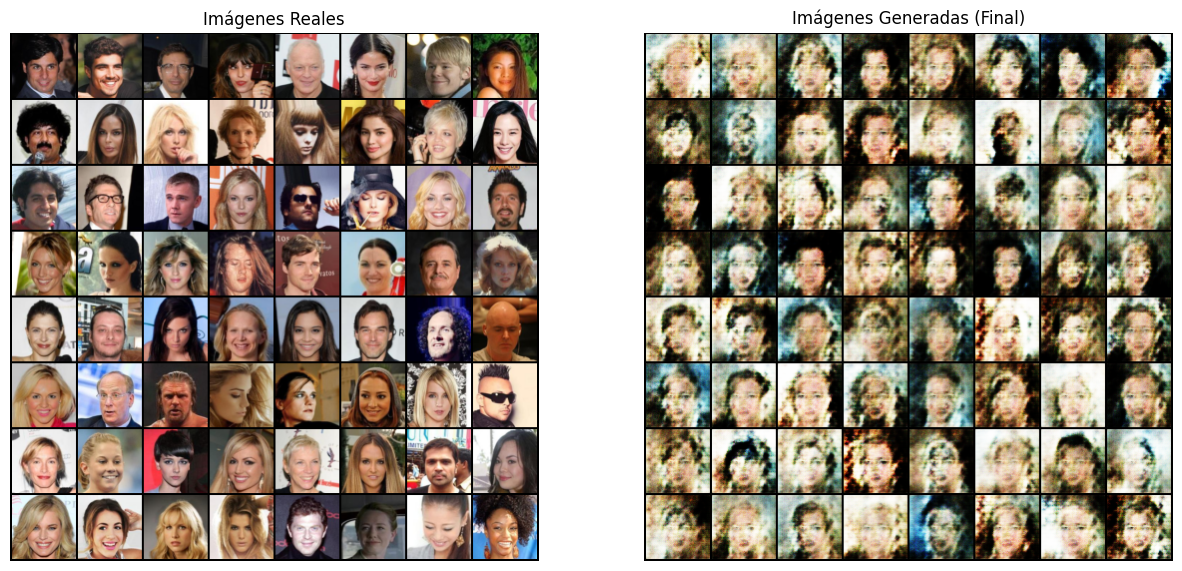

In [9]:
# Generar imágenes finales para visualización
with torch.no_grad():
    noise = torch.randn(64, nz, 1, 1, device=device)
    fake_final = netG(noise).detach().cpu()

# Comparación final: real vs fake
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.axis("off")
plt.title("Imágenes Reales")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(), (1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Imágenes Generadas (Final)")
plt.imshow(np.transpose(vutils.make_grid(fake_final, padding=2, normalize=True), (1,2,0)))

# Agregar FID al título si está disponible
if fid_score is not None:
    plt.suptitle(f"Comparación Final - FID: {fid_score:.2f}", fontsize=14)

plt.savefig('../results/2_dcgan_generation/comparison_final.png', dpi=300, bbox_inches='tight')
plt.show()

# Guardar grid de imágenes generadas
vutils.save_image(fake_final, "../results/2_dcgan_generation/generated_images_final.png",
                 nrow=8, normalize=True)



In [10]:
print("\nGuardando resultados en summary.csv...")

final_g_loss = G_losses[-1] if G_losses else float("nan")
final_d_loss = D_losses[-1] if D_losses else float("nan")

csv_path = "../results/summary.csv"
header = ["model_name", "notebook_name", "test_accuracy", "f1", "test_loss", 
          "epochs", "model_params", "training_time", "final_g_loss", "final_d_loss", "fid_score"]

row = [
    "dcgan_celeba_64",
    "2_dcgan_generation", 
    float("nan"),  # test_accuracy
    float("nan"),  # f1
    final_g_loss,  # test_loss
    num_epochs,
    sum(p.numel() for p in netG.parameters()) + sum(p.numel() for p in netD.parameters()),
    total_time,
    final_g_loss,
    final_d_loss,
    fid_score if fid_score is not None else float("nan")  # Agregar FID
]

write_header = not os.path.exists(csv_path) or os.path.getsize(csv_path) == 0

with open(csv_path, "a", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    if write_header:
        w.writerow(header)
    w.writerow(row)

print("✓ Resultados guardados en summary.csv")




Guardando resultados en summary.csv...
✓ Resultados guardados en summary.csv


## resumen modelo

In [11]:

print("\n" + "="*70)
print("ENTRENAMIENTO COMPLETADO!")
print("="*70)

print(f"Arquitectura:")
print(f"  • Generator: {sum(p.numel() for p in netG.parameters()):,} parámetros")
print(f"  • Discriminator: {sum(p.numel() for p in netD.parameters()):,} parámetros")
print(f"  • Dimensión latente (z): {nz}")

print(f"\nMétricas Finales:")
print(f"  • Pérdida G: {final_g_loss:.4f}")
print(f"  • Pérdida D: {final_d_loss:.4f}")
if fid_score is not None:
    print(f"  • FID Score: {fid_score:.2f}")

print(f"\nConfiguración:")
print(f"  • Épocas: {num_epochs}")
print(f"  • Batch size: {batch_size}")
print(f"  • Learning rate: {lr}")
print(f"  • Tiempo total: {total_time:.2f}s")

print(f"\nArchivos guardados:")
print(f"  • Modelos: generator_final.pth, discriminator_final.pth")
print(f"  • Gráficas: loss_curve.png, comparison_final.png")
print(f"  • Imágenes: generated_images_final.png, epoch_*.png")
print(f"  • Resumen: summary.csv")

print(f"\nUbicación: ../results/2_dcgan_generation/")
print("="*70)


ENTRENAMIENTO COMPLETADO!
Arquitectura:
  • Generator: 3,576,704 parámetros
  • Discriminator: 2,765,568 parámetros
  • Dimensión latente (z): 100

Métricas Finales:
  • Pérdida G: 7.9416
  • Pérdida D: 0.6044

Configuración:
  • Épocas: 5
  • Batch size: 64
  • Learning rate: 0.0002
  • Tiempo total: 1725.87s

Archivos guardados:
  • Modelos: generator_final.pth, discriminator_final.pth
  • Gráficas: loss_curve.png, comparison_final.png
  • Imágenes: generated_images_final.png, epoch_*.png
  • Resumen: summary.csv

Ubicación: ../results/2_dcgan_generation/
